# Multiobjective optimisation

Often, you have more than one objective. A typical example would be a production process where we both want to lower the price and increase the quality of the product.

One approach is to construct a artificial objective function that takes all relevant objectives. However, this is often complicated, if not impossible, to do, especially since you need to do it before you have any data.

Instead, you can do optimisation on all objectives at once. This changes what the `ProcessOptimizer` aims at, since the objectives no longer provides a clear ordering of control parameter settings. For example, if we have the objectives $O_1$ and $O_2$ and the control parameter sets $A$ and $B$, such that $O_1(A)>O_1(B)$ and $O_2(A)<O_2(B)$, it is not clear whether $A$ is a better control parameter setting than $B$.

Instead, `ProcessOptimizer` aims to find points that can not be improved upon without some sacrifice. More stringently, these are points where no other point is as good or better on all objectives, so if you want to improve one objective, you have to accept some other objective becoming worse. Such points are said to be Pareto efficient, and the set of all Pareto efficient points is called the [Pareto front](https://en.wikipedia.org/wiki/Pareto_front).

When `ProcessOptimizer` has more than one objective, the first `n_initial_points` experiments are still found using Latin Hypercube Sampling. Further experiments are suggested using either Steinerberger sampling or estimating the Pareto front and selecting a point on it. Which to use is randomly decided, with Steinerberger sampling having a probability of 0.25, and Pareto front sampling having a probability of 0.75.

## Steinerberger sampling
Stefan Steinerberger [suggested](https://arxiv.org/abs/1902.03269) an iterative algorithm to find points that are uniformly distributed in a high-dimensional space. We us this to find points that are different from the already sampled points as possible in control parameter space. This is the "explorative sampling" of multiobjective optimisation.

## Pareto front sampling
When doing Pareto front sampling, the Pareto front is first estimated using the [NSGA-II algorithm](https://ieeexplore.ieee.org/document/996017). The point on the estimated front that is farthest from the already sampled point is then suggested. This distance takes into account both control parameters and objectives.

The Pareto front sampling here only takes into account the mean value of the predictions - It does not use the estimated uncertainties.

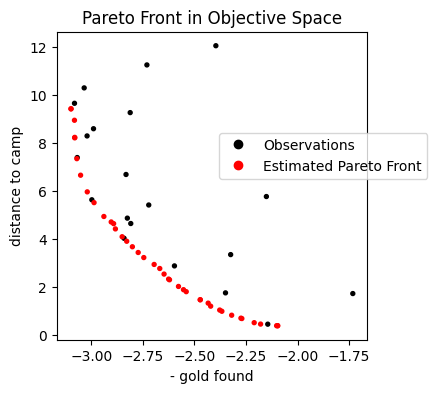

In [3]:
import ProcessOptimizer as po
from ProcessOptimizer.model_systems import get_model_system
from ProcessOptimizer import Optimizer

# Define the model system
gold_model_system = get_model_system("gold_map")
distance_model_system = get_model_system("distance_map")

space = distance_model_system.space

opt = Optimizer(space, n_initial_points=4, n_objectives=2)

for i in range(20):
    new_dig_site = opt.ask()
    gold_found = gold_model_system.get_score(new_dig_site)
    distance = distance_model_system.get_score(new_dig_site)
    result = opt.tell(new_dig_site, [gold_found, distance])

po.plot_Pareto(optimizer=opt, figsize = [4,4], objective_names=["- gold found", "distance to camp"], return_data=True);



If you have ipyml installed, you can get the plot of the Pareto front interactive, where each point have a popup showing the control parameters producing the point when you hover over it with your mouse:

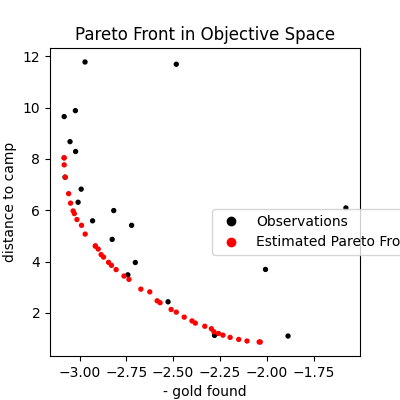

In [2]:
#ipympl is needed for the following cell to render. without ipympl, the user is still able to run po.plot_pareto(optimizer) but the plot will not be interactive.
%matplotlib widget
po.plot_Pareto(
    optimizer=opt,
    figsize = [4,4],
    objective_names=["- gold found", "distance to camp"],
    dimensions= ["E-W", "N-S"],
)

## Constraints

At the moment, multi-objective optimisations with `ProcessOptimizer` does not work with contraints.

In [5]:
from ProcessOptimizer.space.constraints import Inclusive

opt = po.Optimizer(space, n_initial_points=4, n_objectives=2)
constraint = Inclusive(1,(4.,8.),dimension_type="real")
opt.set_constraints(constraints=[constraint])


RuntimeError: Can't set constraints for multiobjective optimization. The NSGA-II algorithm             used for multiobjective optimization does not support constraints.

## Dimension types